In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import cv2
import json
import glob
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import nn, optim
from torchvision import datasets, transforms, models
from torchvision.ops import sigmoid_focal_loss
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Use ImageNet normalization for pretrained ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# FYI: class_to_idx determines 0/1 mapping based on folder names (alphabetical)
print("class_to_idx:", train_dataset.class_to_idx)

# Build model
model = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device)

# Freeze everything
for p in model.parameters():
    p.requires_grad = False

class_to_idx: {'Negative': 0, 'Positive': 1}


Using cache found in /home/ai-17/.cache/torch/hub/facebookresearch_dinov2_main
/home/ai-17/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ai-17/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ai-17/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [14]:
model.norm

LayerNorm((384,), eps=1e-06, elementwise_affine=True)

In [15]:
# Replace classifier with single-logit binary head
# in_features = model.norm.in_features
in_features = 384
model.head = nn.Linear(in_features, 1).to(device)
model.head.requires_grad_(True)

optimizer = optim.Adam(model.head.parameters(), lr=1e-3)
def focal_criterion(logits, targets, alpha=0.25, gamma=2.0):
    # logits: (N,1), targets: float (N,1) with 0/1
    return sigmoid_focal_loss(
        inputs=logits,           # raw logits
        targets=targets,         # 0/1 floats, same shape
        alpha=alpha,
        gamma=gamma,
        reduction="mean"
    )
    

In [16]:
def train_one_epoch():
    model.train()
    running = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # (N,1)

        logits = model(imgs)   # (N,1)
        loss = focal_criterion(logits, labels, alpha=0.25, gamma=2.0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item() * imgs.size(0)
    return running / len(train_loader.dataset)

@torch.no_grad()
def evaluate():
    model.eval()
    correct = total = 0
    total_loss = 0.0
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        y = labels.float().unsqueeze(1).to(device)
        logits = model(imgs)
        total_loss += focal_criterion(logits, y).item() * imgs.size(0)

        preds = (torch.sigmoid(logits).squeeze(1) > 0.5).long()
        correct += (preds.cpu() == labels).sum().item()
        total += labels.size(0)
    return correct / total, total_loss / total

In [19]:
for epoch in range(10):
    train_loss = train_one_epoch()
    acc, val_loss = evaluate()
    print(f"epoch {epoch+1}: loss {train_loss:.4f} | acc {acc:.3f} | loss {val_loss:.3f}")

epoch 1: loss 0.0285 | acc 0.843 | loss 0.035
epoch 2: loss 0.0281 | acc 0.848 | loss 0.034
epoch 3: loss 0.0280 | acc 0.848 | loss 0.034
epoch 4: loss 0.0282 | acc 0.848 | loss 0.035
epoch 5: loss 0.0275 | acc 0.853 | loss 0.034
epoch 6: loss 0.0271 | acc 0.857 | loss 0.035
epoch 7: loss 0.0271 | acc 0.853 | loss 0.034
epoch 8: loss 0.0267 | acc 0.839 | loss 0.034
epoch 9: loss 0.0264 | acc 0.843 | loss 0.035
epoch 10: loss 0.0268 | acc 0.862 | loss 0.034


              precision    recall  f1-score   support

    Negative     0.8671    0.9554    0.9091       157
    Positive     0.8409    0.6167    0.7115        60

    accuracy                         0.8618       217
   macro avg     0.8540    0.7860    0.8103       217
weighted avg     0.8598    0.8618    0.8545       217

Confusion Matrix:
 [[150   7]
 [ 23  37]]


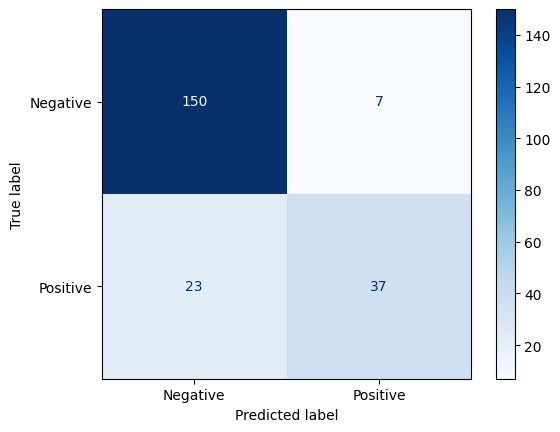

In [20]:
@torch.no_grad()
def evaluate_predictions():
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        probs = torch.sigmoid(logits).squeeze(1)
        preds = (probs > 0.5).long()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    return all_labels, all_preds, all_probs


# ---- Generate reports ----
labels, preds, probs = evaluate_predictions()

# Classification report (precision, recall, f1)
print(classification_report(labels, preds, target_names=train_dataset.classes, digits=4))

# Confusion matrix
cm = confusion_matrix(labels, preds)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues")
plt.show()
